<img src="../assets/data_analysis_with_polars_copyright-1.png" width="600"/>

This notebook is a free sample from the Data Analysis with Polars course on Udemy.

Use this link to do the full course at half price: https://www.udemy.com/course/data-analysis-with-polars/?couponCode=POLARS_HALF_PRICE



# Visualisation
By the end of this lecture on you will be able to:
- create charts from Polars with Matplotlib, Seaborn, Plotly and Altair
- understand how these libraries support Polars

We import Vegafusion along with Altair below. Vegafusion is not necessary but reduces the burden on your browser for visualising larger datasets. See my blog post here for more on this: https://www.rhosignal.com/posts/polars-and-altair/

In [27]:
# %pip install polars matplotlib seaborn plotly altair vegafusion[embed]

In [2]:
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import altair as alt
import vegafusion as vf

# Enable vegafusion for Altair
vf.enable()

/Users/liambrannigan/anaconda3/envs/base310/lib/python3.10/site-packages/xarray/backends/cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


vegafusion.enable(mimetype='html', row_limit=10000, embed_options=None)

In [3]:
csvFile = '../data/titanic.csv'

In [4]:
df = pl.read_csv(csvFile)
df.head(3)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
1,0,3,"""Braund, Mr. Ow…","""male""",22.0,1,0,"""A/5 21171""",7.25,null,"""S"""
2,1,1,"""Cumings, Mrs. …","""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""C"""
3,1,3,"""Heikkinen, Mis…","""female""",26.0,0,0,"""STON/O2. 31012…",7.925,null,"""S"""


We first look at whether we can pass a Polars `DataFrame` directly to each plotting library by creating a simple bar chart. Below we consider some other points to be aware of for working with each library from Polars.

## Bar chart

We begin by getting a count of the number of passengers in each passenger class. See the section of the course on Statistics and Aggregation for more on the methods used here.

In [5]:
passenger_class_counts_df = (
    df['Pclass']
    .value_counts()
    .sort("Pclass")
)
passenger_class_counts_df

Pclass,counts
i64,u32
1,216
2,184
3,491


### Matplotlib
We can pass the columns of the `passenger_class_counts_df` directly to Matplotlib

<BarContainer object of 3 artists>

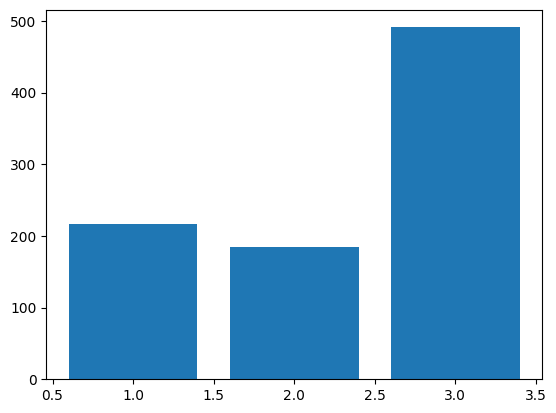

In [6]:
plt.bar(
    x=passenger_class_counts_df["Pclass"],
    height=passenger_class_counts_df["counts"]
)

Note that the `Pclass` column is an integer column in Polars but the x-axis in the chart is a float axis. One way to make this appear as an integer axis is to cast the integers to strings

<BarContainer object of 3 artists>

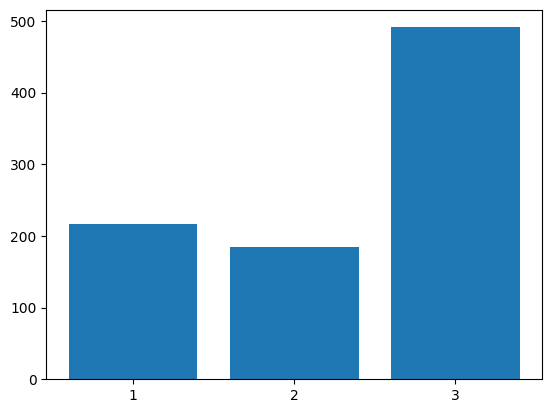

In [7]:
passenger_class_counts_string_column_df = (
    passenger_class_counts_df
    .with_columns(
        pl.col("Pclass").cast(pl.Utf8)
    )
)
plt.bar(
    x=passenger_class_counts_string_column_df["Pclass"],
    height=passenger_class_counts_string_column_df["counts"]
)

Matplotlib does not have explicit support for Polars. However, Matplotlib can accept a Polars `Series` as it just needs sequence-type objects that it can iterate through using standard python methods (that a `Series` supports).

### Seaborn
For basic charts in Seaborn we must convert to Pandas. In this example we can use the pyarrow extension array option to avoid copying the data. I haven't tested this extensively for different chart types - if you come across an issue I recommend just using the standard `.to_pandas` method.

<Axes: xlabel='Pclass', ylabel='counts'>

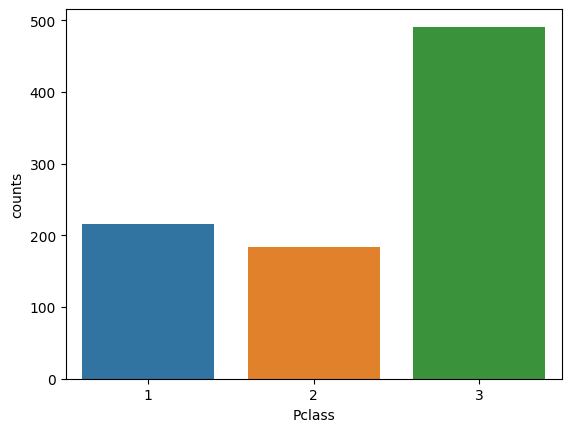

In [8]:
sns.barplot(
    passenger_class_counts_df.to_pandas(use_pyarrow_extension_array=True),
    x="Pclass",
    y="counts"
)

Some Seaborn charts do accept a Polars `DataFrame` directly such as `sns.scatterplot` or `sns.jointplot`. In this example we do a joint plot of (log) Age and (log) Fare coloured by passenger class

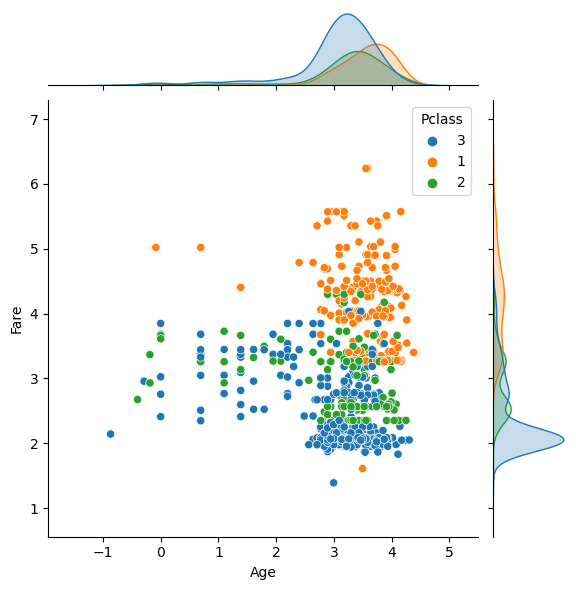

In [9]:
sns.jointplot(
    data=(
        df
        .with_columns(
            [
                pl.col(pl.Float64).log(),
                pl.col("Pclass").cast(pl.Utf8)
            ]
        )
    ),
    x="Age", 
    y="Fare", 
    hue="Pclass",
)

Be aware that support for Polars by Seaborn in this case was not intended. Seaborn has extensive Pandas-integration and does not plan to support Polars at this point. Either Polars or Seaborn may change in future such that these plots no longer accept a Polars `DataFrame` directly and conversion to Pandas is required.

### Plotly
We can pass a `DataFrame` directly to Plotly - note that we again use the `DataFrame` with a string column for correct output

> The Plotly charts display in some notebooks but not in others, I'm looking into why that is

In [26]:
px.bar(
    passenger_class_counts_string_column_df,
    x="Pclass",
    y="counts",
    color="Pclass",
    width=400
)

### The Dataframe Interchange Protocol
Plotly (and Altair below) supports Polars via the **Dataframe Interchange Protocol** ([read more here](https://data-apis.org/dataframe-protocol/latest/index.html)). This protocol is a way for 3rd-party packages (e.g. visualisation libraries) to work with different dataframe libraries without explicitly supporting the libraries.

What the use of the interchange protocol means in practice is that we can use Polars `DataFrames` directly with Plotly for many charts. However, as Polars does not have native support from Plotly there are no guarantees all plots will work with a Polars `DataFrame`. You may need to convert to Pandas in some cases.

If you are curious about how the interchange protocol works this is a simplified version:
- Plotly checks the type of the data object passed to it and finds that it is not a Pandas `DataFrame`
- Plotly then checks to see if the object passed to it has a `__dataframe__` namespace
- if Plotly finds the object has a `__dataframe__` namespace it uses the generic commands in that namespace to do what it needs (e.g. extract a named column from the `DataFrame`, check the dtype of the column and iterate through the column)

You can see the methods in the `__dataframe__` namespace on a Polars `DataFrame` here: 

In [11]:
[el for el in dir(df.__dataframe__()) if not el.startswith("__")]

['_allow_copy',
 '_df',
 '_get_chunks_from_col_chunks',
 'column_names',
 'get_chunks',
 'get_column',
 'get_column_by_name',
 'get_columns',
 'metadata',
 'num_chunks',
 'num_columns',
 'num_rows',
 'select_columns',
 'select_columns_by_name']

These methods are wrappers for the standard Polars methods we learn on this course. The dataframe interchange is a rapidly developing project in its own right and so expect functionality to grow.

### Altair
We can pass a `DataFrame` directly to Altair

In [12]:
alt.Chart(
    passenger_class_counts_df,
    width=600
).mark_bar().encode(
    x="Pclass:N",
    y="counts:Q",
    color="Pclass:N",
)

alt.Chart(...)

As with Plotly, Altair supports Polars via the Dataframe Interchange Protocol. The same caveats apply as for Plotly.

## Exercises
In the exercises you will develop your understanding of:
- creating charts via Pandas or directly from Polars

### Exercise 1
We first create a `DataFrame` of bike sales and replace spaces in the string column names with `_` (see the lecture on Transforming DataFrames in the section of selecting and transforming data for more on `pipe`)

In [13]:
df_bike = (
    pl.read_parquet("../data/bike_sales.parquet")
    .pipe(lambda df: df.rename({col:col.replace(" ","_") for col in df.columns}))
)
df_bike.head(2)

date,customer_age,customer_gender,country,sub_category,order_quantity,unit_cost,unit_price,cost,revenue
date,i64,str,str,str,i64,i64,i64,i64,i64
2013-01-28,31,"""M""","""Australia""","""Mountain Bikes…",1,1912,3400,1912,2856
2015-01-28,31,"""M""","""Australia""","""Mountain Bikes…",1,1912,3400,1912,2856


We need to do a `groupby` first to get the data

In [14]:
customer_count_df = (
    df_bike
    .groupby("customer_age")
    .count()
    .sort("customer_age")
)

Using your preferred visualisation library make a bar chart of the `customer_age` column showing the number of bikes sold by customer_age

<blank>

## Solutions

### Matplotlib

<BarContainer object of 55 artists>

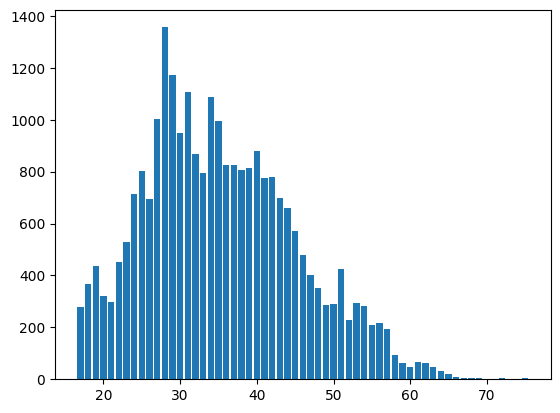

In [19]:
plt.bar(
    x=customer_count_df["customer_age"],
    height=customer_count_df["count"],
)

### Seaborn

<Axes: xlabel='customer_age', ylabel='count'>

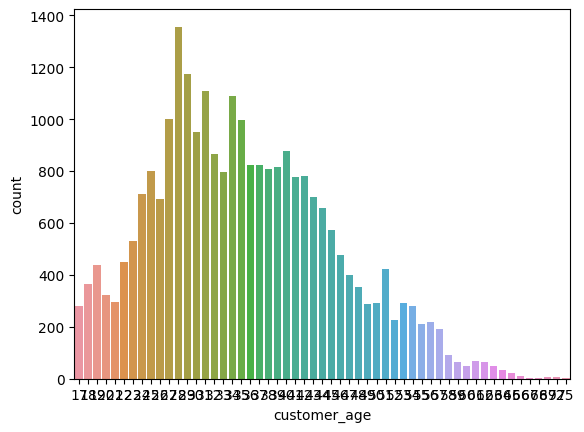

In [20]:
sns.barplot(
    customer_count_df.to_pandas(use_pyarrow_extension_array=True),
    x="customer_age",
    y="count"
)

### Plotly

In [21]:
px.bar(
    customer_count_df.with_columns(pl.col("customer_age").cast(pl.Utf8)),
    x="customer_age",
    y="count",
)

### Altair

In [22]:
(
    alt.Chart(
    customer_count_df,
        width=600
    )
    .mark_bar()
    .encode(
        x="customer_age:N",
        y="count:Q"
    )
)

alt.Chart(...)